In [1]:
# Add parent directory to the path so we can import from there
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import copy

# Import hex maze functions for path calculation and choice points
from hex_maze.hex_maze_utils import get_path_independent_hexes_to_port


### Define all of our functions here for now so we can see everything

Functions for loading things

In [2]:
def reduce_df_mem_usage(df, print_mem_usage=True):
    ''' 
    Given a DataFrame, return an optimized DataFrame that uses less memory. 
    
    Args:
    df (DataFrame): The DataFrame to optimize
    print_mem_usage (bool): Optional. Print the memory usage of the
    DataFrame before and after optimization. Defaults to True

    Returns:
    DataFrame: memory-optimized version of the original DataFrame
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    if (print_mem_usage):
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    if (print_mem_usage):
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))  
    return df


def add_total_trials_to_df(df):
    '''
    Add a total_trials column to the DataFrame enumerating
    each time the 'tri' column changes. This is useful to 
    track trials for DataFrames that combine multiple sessions. 
    
    This should be run on DataFrames that have been cleaned with
    clean_session_dfs to avoud counting the "trials" of <10 samples
    that occur directly before a block changes 

    Args:
    df (DataFrame): Combined DataFrame for multiple rats/sessions

    Returns:
    DataFrame: The DataFrame with a total_trials column added
    '''
    # Find each time a trial changes
    trial_ends = df.index[df['tri'] != df['tri'].shift()][1:].tolist()
    # Make sure to include the end of the DataFrame as the last trial end
    trial_ends.append(df.index[-1])
    # Enumerate each trial at the trial end index in a new column 'total_trials'
    df.loc[trial_ends, 'total_trials'] = range(sum(trial_ends))
    # Backfill each trial number from the trial end point
    df['total_trials'] = df['total_trials'].astype(float).bfill()
    return df


def clean_session_df(df, print_info=True):
    '''
    Clean the DataFrame for a session. Removes extra samples after the last
    valid trial (trial with a port entry) of the session. Also ensures that
    trial changes are aligned with block changes, removing misaligned "trials"
    of <10 samples directly before a block change. These samples will be reassigned
    to the previous trial.

    Args:
    df (DataFrame): A dataframe for a single session
    print_info (bool): Optional. Prints info about the cleaning being done.
    Defaults to True

    Returns:
    DataFrame: a cleaned version of the dataframe where each trial has exactly
    one port entry
    '''
    # Step 1: remove the extra samples after the last valid trial of the session.
    # The last valid trial is the last trial with a port entry.

    # Find the index of the last port entry in this session
    last_port_entry_idx = df[df['port'] != -100].index[-1]
    # Find which trial this occurs in
    last_valid_trial = df.loc[last_port_entry_idx, 'tri']
    # Find the end index of this trial
    df_after_last_entry = df.loc[last_port_entry_idx:]
    last_valid_trial_end = df_after_last_entry.index[df_after_last_entry['tri'] != last_valid_trial][0]

    if print_info:
        print(f"The last port entry in this session occured at index {last_port_entry_idx} in trial {int(last_valid_trial)}.")
        print(f"This trial ended at index {last_valid_trial_end}.")
        print(f"The dataframe ends at index {len(df)}. Removing the last {len(df)-last_valid_trial_end} samples ({(len(df)-last_valid_trial_end)/250} seconds)\n")

    # Remove the extra samples after the last valid trial
    clean_df = df.loc[:last_valid_trial_end - 1]

    # Step 2: Adjust the last residual trial in each block to ensure all trials 
    # have a port entry 

    # Find where the blocks change
    block_change_indices = clean_df.index[clean_df['block'] != clean_df['block'].shift()][1:].tolist()
    if print_info:
        print(f"The blocks change at indices: {block_change_indices}")
    trial_change_indices = clean_df.index[clean_df['tri'] != clean_df['tri'].shift()][1:].tolist()

    for block_num, block_change in enumerate(block_change_indices, start=1):
        # Find the index of the last trial change before the block change
        tri_change_before_block = max((idx for idx in trial_change_indices if idx < block_change), default=None)
        if print_info:
            print(f"For the block ending at index {block_change}, the last trial change in this block is at index {tri_change_before_block}")
    
        # Find the number of this trial
        trial_num = clean_df.loc[tri_change_before_block, 'tri']
        # Find the indices of this trial
        last_trial_indices = clean_df[(clean_df['block'] == block_num) & 
                                      (clean_df['tri'] == trial_num)].index
        if print_info:
            print(f"Trial {trial_num} at the end of block {block_num} spans {len(last_trial_indices)} indices ({len(last_trial_indices)/250} seconds):")
            print(last_trial_indices)
            print(f"These indices are being reassigned to the end of trial {trial_num-1}\n")

        # Reassign the last few indices to the previous trial
        if (len(last_trial_indices) <=250):
            clean_df.loc[last_trial_indices, 'tri'] = trial_num-1
        else:
            # Non-optional warn just in case
            print("Reassigning over 1 second of data - double check this is not a legitimate trial!! \n")
    
    return clean_df


def load_session_dfs(session_dict, directory='/Volumes/Tim/Ephys'):
    '''
    Load all DataFrames for the specified sessions.
    Ensure position data has been interpolated and hexlabels have
    been filled between missing camera frames.
    Adds a total_trials column enumerating trials across all sessions.

    Args:
    session_dict (dict): Dictionary specifying the sessions to load, 
    where the keys are rats and the values are dates
    directory (string): The base directory prefix to load from. 
    The assumed directory structure is {directory}/{rat}/{date}/etc,
    where the rats and dates are specified by session_dict

    Returns:
    Dataframe: A combined DataFrame for all specified rats and dates.
    '''
    all_dataframes = []
    session = 1
    for rat in session_dict:
        for date in session_dict[rat]:
            # Load dataframe and add column identifying this session
            session_df = attempt_df_load(rat, date, directory)
            session_df["session"] = session
            # Ensure that position data has been interpolated
            session_df["x"] = session_df["x"].interpolate()
            session_df["y"] = session_df["y"].interpolate()
            # Ensure hexlabels have been filled between missing camera frames
            # (replace -1 with NaN so we can use ffill to forward fill the hex labels)
            session_df["hexlabels"] = session_df["hexlabels"].replace(-1, np.nan)
            session_df["hexlabels"] = session_df["hexlabels"].astype(float).ffill()
            # Make sure all trials are valid and aligned
            cleaned_session_df = clean_session_df(session_df, True)
            # Add this session to our list of dataframes
            all_dataframes.append(cleaned_session_df)
            session += 1
    # Combine all session dataframes into a single dataframe
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    # Add a total_trials column enumerating trials across all sessions
    #print("done loading")
    #combined_df = add_total_trials_to_df(combined_df)
    return combined_df


def attempt_df_load(rat, date, directory='/Volumes/Tim/Ephys'):
    '''
    Attempt to load a DataFrame for the given rat and date.
    The assumed directory structure is {directory}/{rat}/{date}/etc
    Complain if the load fails. 

    Args:
    rat (string): The ID of the rat
    date (string): The date to load, in MMDDYYYY format
    directory (string): The base directory to load from

    Returns:
    new_df (DataFrame): The loaded Dataframe, or None if the load failed
    '''
    try:
        df_path = f"{directory}/{rat}/{date}/phot_decode_df_withHexStates.csv"
        new_df = reduce_df_mem_usage(pd.read_csv(df_path))
        return new_df
    except:
        print(f"Could not load df for {rat}; {date}")
        print(f"Attempted load path was: {df_path}")


def attempt_load_barriers(rat, date, directory='/Volumes/Tim/Photometry'):
    '''
    Attempt to load a list of barriers for the given rat and date.
    The assumed directory structure is {directory}/{rat}/{date}/etc
    Complain if the load fails. 

    Args: 
    rat (string): The ID of the rat
    date (string): The date to load, in MMDDYYYY format
    directory (string): The base directory to load from

    Returns:
    barrier_sequence (list of sets): List of barrier sets used in this session,
    or an empty list if the load failed
    '''
    barrier_sequence = []
    try:
        barriers_path = f"{directory}/{rat}/{date}/barriers.txt"
        # Read from the text file and append each set to the list
        with open(barriers_path, 'r') as txtfile:
            for line in txtfile:
                # Ignore any empty lines or lines starting with '#'
                if line.strip().startswith('#') or not line.strip():
                    continue
                # Strip any leading/trailing whitespace and split by commas
                barriers_string = line.strip().split(',')
                # Convert each number to an integer and create a set
                barrier_set = set(map(int, barriers_string))
                barrier_sequence.append(barrier_set)
            return barrier_sequence
    except:
        print(f"Could not load barriers for {rat}; {date}")
        print(f"Attempted load path was: {barriers_path}")
        return []


def nested_dict_to_df(nested_dict, metadata=True):
    '''
    Make our nested dictionary nexted_dict[session][block][trial] into a dataframe.
    Option to include or exclude session and block-level metadata.

    Args:
    nested_dict (dict): Nested dictionary of trial-level data in the format
    nested_dict[session][block][trial], with session and block-level metadata 
    nested_dict[session]['metadata'] and nested_dict[sesison][block]['metadata']
    metadata (bool): If we should include metadata info as columns in our new dataframe.
    Defaults to True

    Returns:
    DataFrame: the dictionary flattened into a DataFrame    
    '''

    # Set up list to flatten the nested dict
    flattened_data = []

    # Create copy of the dict so we can pop
    copied_dict = copy.deepcopy(nested_dict)

    # Iterate through sessions, blocks, and trials
    for session_key, session_data in copied_dict.items():
        session_metadata = session_data.pop('metadata', {})
        for block_key, block_data in session_data.items():
            block_metadata = block_data.pop('metadata', {})
            for trial_key, trial_data in block_data.items():
                # Add info for each trial
                row = {
                    'session': int(session_key),
                    'block': int(block_key),
                    'trial': int(trial_key),
                    **trial_data
                }
                # Add session and block-level metadata
                if metadata:
                    row.update(session_metadata)
                    row.update(block_metadata)
                flattened_data.append(row)
    return(pd.DataFrame(flattened_data))

In [4]:
# These are the 10 sessions used in Tim's poster
sesh_dict = {"IM-1478":["07192022", "07202022", "07242022", "07252022", "07262022", "07272022"],
             "IM-1594":["07252023", "07262023", "07272023", "07282023"]}
ephys_directory = '/Volumes/Tim/Ephys'

# Load dataframes for these sessions into a combined df
df = load_session_dfs(sesh_dict, directory=ephys_directory)

Memory usage of dataframe is 534.37 MB
Memory usage after optimization is: 125.24 MB
Decreased by 76.6%
The last port entry in this session occured at index 1729655 in trial 57.
This trial ended at index 1729767.
The dataframe ends at index 1751025. Removing the last 21258 samples (85.032 seconds)

The blocks change at indices: [450737, 1078884]
For the block ending at index 450737, the last trial change in this block is at index 450731
Trial 65 at the end of block 1 spans 6 indices (0.024 seconds):
Index([450731, 450732, 450733, 450734, 450735, 450736], dtype='int64')
These indices are being reassigned to the end of trial 64

For the block ending at index 1078884, the last trial change in this block is at index 1078876
Trial 62 at the end of block 2 spans 8 indices (0.032 seconds):
Index([1078876, 1078877, 1078878, 1078879, 1078880, 1078881, 1078882, 1078883], dtype='int64')
These indices are being reassigned to the end of trial 61

Memory usage of dataframe is 522.47 MB
Memory usage 

In [5]:
# Add a total_trials column to the dataframe

# Find each time a trial changes
tri_array = df['tri'].to_numpy()
# Find where the value changes
trial_changes = np.where(tri_array[:-1] != tri_array[1:])[0] + 1
# Convert the result to a list and slice as needed
trial_ends = trial_changes.tolist()
# Make sure to include the end of the dataframe as the last trial end
trial_ends.append(df.index[-1])
print(f"There are {len(trial_ends)} trials in this dataframe")
# Enumerate each trial at the trial end index in a new column 'total_trials'
df.loc[trial_ends, 'total_trials'] = range(1, len(trial_ends) + 1)
# Backfill each trial number from the trial end point
df['total_trials'] = df['total_trials'].astype(float).bfill()

display(df)

There are 1681 trials in this dataframe


,Unnamed: 0,index,green_z_scored,port,rwd,x,y,nom_rwd_a,nom_rwd_b,beamA,...,frame,ref,fromP,470,nextprob,nextp,simple_rr,pchosen,Unnamed: 0.2,total_trials
0,0,81873601,1.759766,-100,0,324.500,53.65625,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,81873602,1.776367,-100,0,324.500,53.71875,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2,81873603,1.774414,-100,0,324.500,53.81250,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,3,81873604,1.750000,-100,0,324.500,53.87500,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,4,81873605,1.703125,-100,0,324.500,53.93750,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15590315,1779762,1779762,-1.080078,-100,0,146.500,85.31250,50.0,10.0,0.0,...,1779753.0,0.507324,1.0,1242902.500,10.0,1.0,0.0,NaN,1774121.0,1681.0
15590316,1779763,1779763,-1.120117,-100,0,146.625,85.31250,50.0,10.0,0.0,...,1779753.0,0.551270,1.0,1242789.125,10.0,1.0,0.0,NaN,1774122.0,1681.0
15590317,1779764,1779764,-1.178711,-100,0,146.625,85.31250,50.0,10.0,0.0,...,1779753.0,0.643066,1.0,1242447.875,10.0,1.0,0.0,NaN,1774123.0,1681.0
15590318,1779765,1779765,-1.249023,-100,0,146.750,85.25000,50.0,10.0,0.0,...,1779753.0,0.746582,1.0,1241972.375,10.0,1.0,0.0,NaN,1774124.0,1681.0


In [6]:
print(df.columns)

# Drop useless columns
columns_to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2']
df = df.drop(columns=columns_to_drop)


Index(['Unnamed: 0', 'index', 'green_z_scored', 'port', 'rwd', 'x', 'y',
       'nom_rwd_a', 'nom_rwd_b', 'beamA', 'beamB', 'beamC', 'tri', 'block',
       'nom_rwd_c', 'hexlabels', 'lenAC', 'lenBC', 'lenAB', 'dtop', 'fiberloc',
       'session_type', 'session', 'rat', 'date', 'lastleave', 'nom_rwd_chosen',
       'vel', 'pairedHexStates', 'acc', 'decodeDistToRat', 'decodeHPD',
       'x_pred', 'y_pred', 'mua', 'theta_env', 'theta_phase',
       'theta_phase_bin', 'pred_hexlabels', 'pred_hexState', 'Unnamed: 0.1',
       'tot_tri', 'decodedVal', 'localVal', 'level_0', 'green', 'pA', 'pB',
       'pC', 'frame', 'ref', 'fromP', '470', 'nextprob', 'nextp', 'simple_rr',
       'pchosen', 'Unnamed: 0.2', 'total_trials'],
      dtype='object')


For each trial: find which hexes are represented in ripples at the reward port

In [7]:
#inputs: df
#outputs: nonlocal hex dict

# TODO: use velocity info??
# Get indices where the rat's velocity transitions from < 5 to >= 5
# running_start_indices = np.flatnonzero(np.diff(df['vel'] < 5) == -1)

# Hexes 2-3 away from a reward port (if a rat is here, he has exited the port)
start_path_hexes = [38,47,32,42,43,33,28,39,5,6,7,8]
rat_in_start_path = df.index[df['hexlabels'].isin(start_path_hexes)]

mua_thresh = 5
nonlocal_thresh = 30 # decode must be >30cm from rat to be considered nonlocal
hpd_thresh = 800

# Get indices of nonlocal epochs (>30cms from rat and sufficient MUA)
nonlocal_indices = df.index[(df['decodeDistToRat'] > nonlocal_thresh) & 
                            (df['mua'] > mua_thresh) &
                            (df['pred_hexlabels'] != -1) &
                            (df['decodeHPD'] < hpd_thresh)].tolist()
    
# Initialize column for the stretch of time after port entry before running start
df["rest_at_port"] = 0

# Initialize a dictionary for which hexes were represented in ripples after each port entry
nonlocal_hex_dict = {}

for session, session_df in df.groupby('session'):
    # Get indices of when the rat enters the reward port (one per trial)
    port_entry_indices = session_df.index[session_df['port'] != -100].tolist()
    for port_entry_idx in tqdm(port_entry_indices):
        # Find the first index where the rat is 2-3 hexes from the reward port following port entry
        # (This is done slightly oddly but it is 50x faster than using df.index)
        if port_entry_idx == port_entry_indices[-1]:
            # If it's the last port entry, the exit is the last sample we have for this session
            port_exit_idx = session_df.index[-1]
        else:
            port_exit_idx = rat_in_start_path[rat_in_start_path > port_entry_idx][0]

        # The time between port entry and exit is when the rat is at rest at the port
        # (Add this column to the full df not the session_df)
        df.loc[port_entry_idx:port_exit_idx,"rest_at_port"] = 1

        # How long (in samples) is each hex represented in ripples during this time?
        nonlocal_hex_reps = session_df.loc[(session_df.index > port_entry_idx) & 
                                       (session_df.index <= port_exit_idx) & 
                                       session_df.index.isin(nonlocal_indices), 
                                       "pred_hexlabels"].value_counts()
    
        # Create dict with the port, rwd, and {hexID: samples_repped, hexID: samples_repped, ...}
        trial_num = session_df.loc[port_entry_idx, "total_trials"]
        nonlocal_hex_dict[trial_num] = {
            "port": session_df.loc[port_entry_idx, "port"],
            "rwd": session_df.loc[port_entry_idx, "rwd"],
            "nonlocal_hex_reps": {hexID: count for hexID, count 
                              in zip(nonlocal_hex_reps.index, nonlocal_hex_reps.values)}}

100%|██████████| 165/165 [00:15<00:00, 10.82it/s]


In [8]:
# We need to make sure all hexlabels are valid here because at the next step, we use the rat's hex path
# This could (should) be added to clean_session_df but it's here for now. Will clean later.
print(df.columns)
display(df)

# If we have NaN in hexlabels or pred_hexlabels, replace with -1 to avoid errors
nans_in_hexlabels = df['hexlabels'].isna().sum()
print(f"There are {nans_in_hexlabels} NaN in hexlabels. Replacing them with -1.")
nans_in_pred_hexlabels = df['pred_hexlabels'].isna().sum()
print(f"There are {nans_in_pred_hexlabels} NaN in pred_hexlabels. Replacing them with -1.")

# Fill NaNs with -1
df['hexlabels'] = df['hexlabels'].fillna(-1)
df['pred_hexlabels'] = df['pred_hexlabels'].fillna(-1)
print(f"There are now {(df['hexlabels'] == -1).sum()} -1s in hexlabels and {(df['pred_hexlabels'] == -1).sum()} -1s in pred_hexlabels.")

Index(['index', 'green_z_scored', 'port', 'rwd', 'x', 'y', 'nom_rwd_a',
       'nom_rwd_b', 'beamA', 'beamB', 'beamC', 'tri', 'block', 'nom_rwd_c',
       'hexlabels', 'lenAC', 'lenBC', 'lenAB', 'dtop', 'fiberloc',
       'session_type', 'session', 'rat', 'date', 'lastleave', 'nom_rwd_chosen',
       'vel', 'pairedHexStates', 'acc', 'decodeDistToRat', 'decodeHPD',
       'x_pred', 'y_pred', 'mua', 'theta_env', 'theta_phase',
       'theta_phase_bin', 'pred_hexlabels', 'pred_hexState', 'tot_tri',
       'decodedVal', 'localVal', 'level_0', 'green', 'pA', 'pB', 'pC', 'frame',
       'ref', 'fromP', '470', 'nextprob', 'nextp', 'simple_rr', 'pchosen',
       'total_trials', 'rest_at_port'],
      dtype='object')


,index,green_z_scored,port,rwd,x,y,nom_rwd_a,nom_rwd_b,beamA,beamB,...,frame,ref,fromP,470,nextprob,nextp,simple_rr,pchosen,total_trials,rest_at_port
0,81873601,1.759766,-100,0,324.500,53.65625,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
1,81873602,1.776367,-100,0,324.500,53.71875,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
2,81873603,1.774414,-100,0,324.500,53.81250,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
3,81873604,1.750000,-100,0,324.500,53.87500,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
4,81873605,1.703125,-100,0,324.500,53.93750,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15590315,1779762,-1.080078,-100,0,146.500,85.31250,50.0,10.0,0.0,0.0,...,1779753.0,0.507324,1.0,1242902.500,10.0,1.0,0.0,NaN,1681.0,1
15590316,1779763,-1.120117,-100,0,146.625,85.31250,50.0,10.0,0.0,0.0,...,1779753.0,0.551270,1.0,1242789.125,10.0,1.0,0.0,NaN,1681.0,1
15590317,1779764,-1.178711,-100,0,146.625,85.31250,50.0,10.0,0.0,0.0,...,1779753.0,0.643066,1.0,1242447.875,10.0,1.0,0.0,NaN,1681.0,1
15590318,1779765,-1.249023,-100,0,146.750,85.25000,50.0,10.0,0.0,0.0,...,1779753.0,0.746582,1.0,1241972.375,10.0,1.0,0.0,NaN,1681.0,1


There are 13 NaN in hexlabels. Replacing them with -1.
There are 0 NaN in pred_hexlabels. Replacing them with -1.
There are now 13 -1s in hexlabels and 3033177 -1s in pred_hexlabels.


For each trial: get the rat's hex path and the DA in each hex

In [9]:
# inputs: df
# outputs: trial level dict
# df = df.dropna(subset=['total_trials'])

# Initialize a dict to store info by trial_dict[session][block][trial]
trial_dict = {}

# Convert to int so we can use groupby
df['session'] = df['session'].astype('int')
df['block'] = df['block'].astype('int')
df['tri'] = df['tri'].astype('float32')

for session, session_df in df.groupby('session'):
    # Get the session type, rat, and date for this session
    session_type = session_df['session_type'].iloc[0]
    rat = session_df['rat'].iloc[0]
    date = session_df['date'].iloc[0]
    # If the date doesn't have a leading 0 and needs one, add it
    date = '0' + str(date) if not str(date)[0] in ('1', '0') else str(date)
    # Add session-level metadata (date, rat, session type)
    session_metadata = {'date': date, 'rat': rat, 'session_type': session_type}
    trial_dict[session] = {'metadata': session_metadata}
    # Load the barriers for all blocks in this session
    barrier_sequence = attempt_load_barriers(rat, date)
    for block, block_df in session_df.groupby('block'):
        # Add block-level metadata (barriers, reward probabilities)
        block_metadata = {'barriers': barrier_sequence[int(block)-1], 
                          'nom_rwd_a': block_df['nom_rwd_a'].iloc[0],
                          'nom_rwd_b': block_df['nom_rwd_b'].iloc[0], 
                          'nom_rwd_c': block_df['nom_rwd_c'].iloc[0]}
        trial_dict[session][block] = {'metadata': block_metadata}

# Get a subset of the df for a specific session, block, and trial
for (session, block, trial), trial_df in df.groupby(['session', 'block', 'tri']):
    # Find each time the rat enters a new hex in this trial (Replace NaN with -1)
    hex_change_indices = np.where(trial_df['hexlabels'] != trial_df['hexlabels'].shift())[0]

    # Use these to get the rat's hex path for this trial as a list of ints
    hex_path = trial_df['hexlabels'].iloc[hex_change_indices].astype(int).tolist()
    # Remove all instances of -1
    hex_path = [hex for hex in hex_path if hex != -1]

    # Add end index for calculating mean DA + time in hex
    hex_change_indices = np.append(hex_change_indices, len(trial_df))

    # Calculate mean DA for each hex
    mean_hex_da = [trial_df['green_z_scored'].iloc[hex_change_indices[i]:hex_change_indices[i + 1]].mean()
                        for i in range(len(hex_change_indices) - 1)]

    # Calculate time spent in each hex (in samples)
    time_in_hex = [hex_change_indices[i + 1] - hex_change_indices[i]
                      for i in range(len(hex_change_indices) - 1)]

    # TODO:? Not sure how I feel about this but this works for now
    # Get info about which hexes were represented in ripples after each trial 
    nonlocal_info = nonlocal_hex_dict[trial_df['total_trials'].iloc[0]]

    # Add it to our dictionary
    trial_data = {'hex_path': hex_path,
                  'time_in_hex': time_in_hex,
                  'mean_hex_da':  mean_hex_da,
                  'port': nonlocal_info['port'],
                  'rwd': nonlocal_info['rwd'],
                  'nonlocal_hex_reps': nonlocal_info['nonlocal_hex_reps']}
    trial_dict[session][block][trial] = trial_data


/Users/steph/berkelab/SWR/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


In [2]:
# If we don't want to do that whole calculation again every time, we can just save and load
# the trial-level dictionary of hex paths, nonlocal hex reps, and DA in each hex

save = False
load = True

if save:
    # For now, save our trial_dict as a pickle file
    with open('trial_dict_DUPLICATE.pickle', 'wb') as f:
        pickle.dump(trial_dict, f)

if load:
    # Load trial_dict from pickle (trial_dict_10 is the 10 from Tim's poster)
    with open('trial_dict_10.pickle', 'rb') as f:
        trial_dict = pickle.load(f)

In [10]:
# Example of accessing the data and metadata from the trial_dict
print("Session 1 metadata:", trial_dict[1]['metadata'])
print("Block 2 metadata in session 1:", trial_dict[1][2]['metadata'])
print("Trial 4 data in block 2 of session 1:", trial_dict[1][2][4])


Session 1 metadata: {'date': '07192022', 'rat': 'IM-1478', 'session_type': 'barrier'}
Block 2 metadata in session 1: {'barriers': {35, 8, 9, 42, 44, 18, 21, 23, 27}, 'nom_rwd_a': 90.0, 'nom_rwd_b': 10.0, 'nom_rwd_c': 50.0}
Trial 4 data in block 2 of session 1: {'hex_path': [4, 1, 4, 5, 7, 10, 13, 16, 20, 24, 19, 24, 29, 34, 28, 33, 48, 3], 'time_in_hex': [3308, 232, 32, 116, 52, 48, 85, 52, 100, 515, 33, 151, 132, 53, 48, 51, 48, 155], 'mean_hex_da': [-0.2125, -0.665, -0.2673, -0.1101, -0.4714, -0.526, -0.4558, -0.7344, -0.01804, 0.004078, -0.1206, -0.825, -0.281, -0.56, -0.5776, -0.176, 0.0717, 1.032], 'port': 0, 'rwd': 1, 'nonlocal_hex_reps': {16: 35, 13: 33, 17: 21, 14: 10, 10: 7, 11: 5, 7: 2, 33: 1, 3: 1}}


### Are SWRs used to update place values?

Do some analysis checking if the DA in a hex on a path to a reward port is higher if the hex was represented in a SWR on the previous rewarded trial at that port (2 trials ago) vs if that hex wasn't represented

aka replicating Tim's analysis from his poster

In [12]:
from collections import defaultdict

# Go from nested dict to df once again... 
# still deciding how I want to represent things and it feels ugly but I'm fine
trial_df = nested_dict_to_df(trial_dict, metadata=True)

# Find when the rat goes to the same reward port exactly 2 trials apart
trial_diff = 2

# Miminum number of samples a hex needs to be represented in a ripple for it to "count"
min_samples_repped = 1

# If we only want to look at path-dependent hexes
path_dependent_hexes_only = False

# Set up list of dicts to aggregate everything
hex_DA_stats = []

# Get subset of the df of when the rat goes to the same port in the same session and block
# We only compare hex DA within the same session and block, because we want the maze structure to be the same
for (session, block, port), same_port_df in trial_df.groupby(['session', 'block', 'port']):
    # Print some info about the df subset we're looking at
    print(f"Session: {session}, Block: {block}, Port: {port}")
    
    # Get the maze configuration for this session + block
    maze = same_port_df['barriers'].iloc[0]
    # Get the path-independent hexes to the reward port
    # (need to add 1 here to change port from 0,1,2 to corresponding port hex 1,2,3)
    path_independent_hexes = get_path_independent_hexes_to_port(maze, port+1)
    
    # Set up dicts to store changes in DA across all trials in this block
    DA_repped_hexes = defaultdict(list)
    DA_non_repped_hexes = defaultdict(list)

    # Sort by trial to ensure trials are in ascending order (just in case)
    #same_port_df = same_port_df.sort_values(by='trial')
    # Iterate through each row (trial)
    for i in range(len(same_port_df) - 2):
        prev_trial_at_port = same_port_df.iloc[i]
        trial_at_port = same_port_df.iloc[i + 1]
        
        # Only consider port entries that differ by exactly 2 trials
        if not (prev_trial_at_port['trial'] + trial_diff == trial_at_port['trial']):
            continue
        # Only consider trials where the rat was rewarded in the previous trial
        if not (prev_trial_at_port['rwd'] == 1):
            continue

        # Get the mean DA in each hex the rat ran through in the current trial
        current_hex_da = dict(zip(trial_at_port['hex_path'], trial_at_port['mean_hex_da']))

        # Get hexes represented in the post-reward ripple on the previous trial
        nonlocal_hex_reps = [hex for hex, samples_repped 
                             in prev_trial_at_port['nonlocal_hex_reps'].items() 
                             if samples_repped >= min_samples_repped]
        
        # Get the mean DA for hexes that were represented in ripples after the previous trial
        repped_hexes_with_DA = set(current_hex_da.keys()) & set(nonlocal_hex_reps)
        if path_dependent_hexes_only:
            repped_hexes_with_DA = repped_hexes_with_DA - set(path_independent_hexes)
        mean_DA_repped_hexes_this_trial = {hex: current_hex_da[hex] for hex in repped_hexes_with_DA}
        
        # Get the mean DA for hexes that were NOT represented in ripples after the previous trial
        non_repped_hexes_with_DA = set(current_hex_da.keys()) - set(nonlocal_hex_reps)
        if path_dependent_hexes_only:
            non_repped_hexes_with_DA = non_repped_hexes_with_DA - set(path_independent_hexes)
        mean_DA_non_repped_hexes_this_trial = {hex: current_hex_da[hex] for hex in non_repped_hexes_with_DA}

        # Add DA changes for this trial to our block-level dicts for this port
        for hex, hex_DA in mean_DA_repped_hexes_this_trial.items():
            DA_repped_hexes[hex].append(hex_DA)
        for hex, hex_DA in mean_DA_non_repped_hexes_this_trial.items():
            DA_non_repped_hexes[hex].append(hex_DA)
    
    # Now for each block/port, we have a dictionary of change in hex DA 
    # both for hexes represented in ripples and those not represented in ripples.
    # We want to see if this DA increase is higher for hexes represented!!
    hexes_to_compare = set(DA_repped_hexes.keys()).union(DA_non_repped_hexes.keys())

    for hex in hexes_to_compare:
        mean_repped_DA = np.nanmean(DA_repped_hexes.get(hex, []))
        std_repped_DA = np.nanstd(DA_repped_hexes.get(hex, []))
        mean_non_repped_DA = np.nanmean(DA_non_repped_hexes.get(hex, []))
        std_non_repped_DA = np.nanstd(DA_non_repped_hexes.get(hex, []))
        if np.isnan(mean_repped_DA) or np.isnan(mean_non_repped_DA):
            mean_DA_diff = np.nan
        else:
            mean_DA_diff = mean_repped_DA - mean_non_repped_DA
    
        # Add a bunch of stats. Not sure which we will want yet
        hex_DA_stats.append({'session': session,
                             'block': block,
                             'port': port,
                             'maze': maze,
                             'hex': hex,
                             'mean_DA_diff': mean_DA_diff, 
                             'mean_repped_DA': mean_repped_DA, 
                             'std_repped_DA': std_repped_DA,
                             'mean_non_repped_DA': mean_non_repped_DA, 
                             'std_non_repped_DA': std_non_repped_DA})

hex_DA_df = pd.DataFrame(hex_DA_stats)
display(hex_DA_df)

Session: 1, Block: 1, Port: 0
Session: 1, Block: 1, Port: 1
Session: 1, Block: 1, Port: 2
Session: 1, Block: 2, Port: 0
Session: 1, Block: 2, Port: 1
Session: 1, Block: 2, Port: 2
Session: 1, Block: 3, Port: 0
Session: 1, Block: 3, Port: 1
Session: 1, Block: 3, Port: 2
Session: 2, Block: 1, Port: 0
Session: 2, Block: 1, Port: 1
Session: 2, Block: 1, Port: 2
Session: 2, Block: 2, Port: 0
Session: 2, Block: 2, Port: 1
Session: 2, Block: 2, Port: 2
Session: 3, Block: 1, Port: 0
Session: 3, Block: 1, Port: 1
Session: 3, Block: 1, Port: 2
Session: 3, Block: 2, Port: 0
Session: 3, Block: 2, Port: 1
Session: 3, Block: 2, Port: 2
Session: 4, Block: 1, Port: 0
Session: 4, Block: 1, Port: 1
Session: 4, Block: 1, Port: 2
Session: 4, Block: 2, Port: 0
Session: 4, Block: 2, Port: 1
Session: 4, Block: 2, Port: 2
Session: 4, Block: 3, Port: 0
Session: 4, Block: 3, Port: 1
Session: 4, Block: 3, Port: 2
Session: 5, Block: 1, Port: 0
Session: 5, Block: 1, Port: 1
Session: 5, Block: 1, Port: 2
Session: 5

/var/folders/qw/_sndq4457jd616hb6zx68mw80000gn/T/ipykernel_61562/2043910673.py:84: RuntimeWarning: Mean of empty slice
  mean_repped_DA = np.nanmean(DA_repped_hexes.get(hex, []))
/Users/steph/berkelab/SWR/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/qw/_sndq4457jd616hb6zx68mw80000gn/T/ipykernel_61562/2043910673.py:86: RuntimeWarning: Mean of empty slice
  mean_non_repped_DA = np.nanmean(DA_non_repped_hexes.get(hex, []))


Session: 5, Block: 3, Port: 1
Session: 5, Block: 3, Port: 2
Session: 6, Block: 1, Port: 0
Session: 6, Block: 1, Port: 1
Session: 6, Block: 1, Port: 2
Session: 6, Block: 2, Port: 0
Session: 6, Block: 2, Port: 1
Session: 6, Block: 2, Port: 2
Session: 6, Block: 3, Port: 0
Session: 6, Block: 3, Port: 1
Session: 6, Block: 3, Port: 2
Session: 6, Block: 4, Port: 0
Session: 6, Block: 4, Port: 1
Session: 6, Block: 4, Port: 2
Session: 7, Block: 1, Port: 0
Session: 7, Block: 1, Port: 1
Session: 7, Block: 1, Port: 2
Session: 7, Block: 2, Port: 0
Session: 7, Block: 2, Port: 1
Session: 7, Block: 2, Port: 2
Session: 7, Block: 3, Port: 0
Session: 7, Block: 3, Port: 1
Session: 7, Block: 3, Port: 2
Session: 8, Block: 1, Port: 0
Session: 8, Block: 1, Port: 1
Session: 8, Block: 1, Port: 2
Session: 8, Block: 2, Port: 0
Session: 8, Block: 2, Port: 1
Session: 8, Block: 2, Port: 2
Session: 8, Block: 3, Port: 0
Session: 8, Block: 3, Port: 1
Session: 8, Block: 3, Port: 2
Session: 8, Block: 4, Port: 0
Session: 8

,session,block,port,maze,hex,mean_DA_diff,mean_repped_DA,std_repped_DA,mean_non_repped_DA,std_non_repped_DA
0,1,1,0,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",1,NaN,NaN,NaN,-0.279541,0.353271
1,1,1,0,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",2,NaN,NaN,NaN,0.034912,0.553223
2,1,1,0,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",3,0.832031,1.310547,0.0,0.478760,0.553711
3,1,1,0,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",4,0.055664,-0.432373,0.0,-0.488037,0.457520
4,1,1,0,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",5,0.473633,0.121948,0.0,-0.351562,0.328369
...,...,...,...,...,...,...,...,...,...,...
1725,10,3,2,"{32, 34, 35, 12, 45, 46, 15, 21, 26}",43,NaN,NaN,NaN,-0.205688,0.199585
1726,10,3,2,"{32, 34, 35, 12, 45, 46, 15, 21, 26}",44,NaN,0.005226,0.0,NaN,NaN
1727,10,3,2,"{32, 34, 35, 12, 45, 46, 15, 21, 26}",47,NaN,NaN,NaN,0.019058,0.005417
1728,10,3,2,"{32, 34, 35, 12, 45, 46, 15, 21, 26}",48,NaN,NaN,NaN,-0.536621,0.443115


   session  mean_DA_diff
0        1      0.089587
1        2     -0.005611
2        3     -0.010124
3        4     -0.009166
4        5      0.122875
5        6      0.090355
6        7     -0.034427
7        8      0.092794
8        9      0.217823
9       10     -0.120466


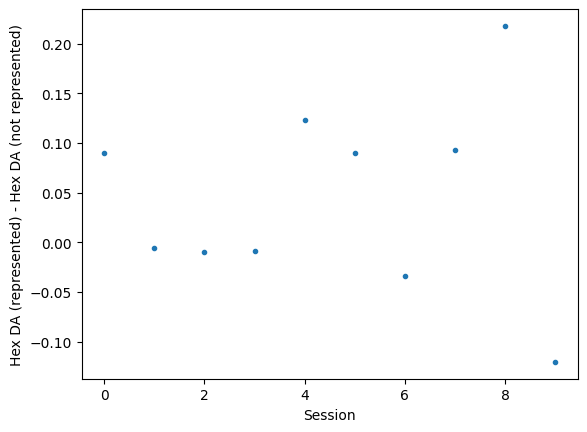

0.04336398062726077


In [13]:
# AVERAGE THIS ACROSS SESSIONS TO GET WHAT TIM GOT

# number of samples per hex in a ripple
#samples_per_hex_rep = [num_samples for d in hex_DA_df['nonlocal_hex_reps'] for num_samples in d.values()]
#print(len(samples_per_hex_rep))

session_avg_hex_diff = hex_DA_df.groupby('session')['mean_DA_diff'].mean().reset_index()

# Print the mean hex DA difference (repped - not repped) by session
print(session_avg_hex_diff)

# Make plot of mean hex DA difference (repped - not repped) by session
plt.figure()
plt.plot(session_avg_hex_diff['mean_DA_diff'], '.')
plt.xlabel('Session')
plt.ylabel('Hex DA (represented) - Hex DA (not represented)')
plt.show()

# Print the overall mean hex DA difference (mean of the above means)
print(session_avg_hex_diff['mean_DA_diff'].mean())

In [14]:
# Is this difference statistically significant? 
from scipy.stats import ttest_rel

# Perform paired t-test for each group
results = []
for session, session_df in hex_DA_df.groupby('session'):
    df = session_df.dropna(subset=['mean_repped_DA', 'mean_non_repped_DA'])
    t_stat, p_value = ttest_rel(df['mean_repped_DA'], df['mean_non_repped_DA'])
    results.append((session, t_stat, p_value))
    
result_df = pd.DataFrame(results, columns=['session', 't_stat', 'p_value'])
display(result_df)

print(result_df['t_stat'].mean())

,session,t_stat,p_value
0,1,2.318641,0.023726
1,2,-0.043920,0.965317
2,3,-0.147702,0.883128
3,4,-0.204180,0.838712
4,5,1.584445,0.122630
5,6,2.025959,0.045603
6,7,-0.702337,0.484483
7,8,0.554900,0.580683
8,9,1.606191,0.118708
9,10,-1.145712,0.262350


0.5846285205782229


### Playing around with some ripple stats

When do nonlocal representations happen and what do they look like?

Histograms and stuff

In [15]:
# Let's calculate some stats about when we see ripples and what the ripples look like
# What is the average length of a ripple on trials with ripples?
# How many hexes are represented per ripple?
trial_df['ripple_length'] = trial_df['nonlocal_hex_reps'].apply(lambda d: sum(d.values()))
trial_df['num_hexes_in_ripple'] = trial_df['nonlocal_hex_reps'].apply(lambda d: len(d.keys()))

# All trials
num_trials_with_ripples = trial_df['nonlocal_hex_reps'].apply(lambda x: len(x) != 0).sum()
num_trials_with_no_ripples = trial_df['nonlocal_hex_reps'].apply(lambda x: len(x) == 0).sum()
print(f"There are {len(trial_df)} trials.")
print(f"{num_trials_with_ripples} ({num_trials_with_ripples/len(trial_df):.3f}%) trials had post-port nonlocal hex representations.")
print(f"{num_trials_with_no_ripples} ({num_trials_with_no_ripples/len(trial_df):.3f}%) trials did not have post-port nonlocal hex representations.")
mean_ripple_length = trial_df.loc[trial_df['ripple_length'] != 0, 'ripple_length'].mean()
mean_hexes_in_ripple = trial_df.loc[trial_df['num_hexes_in_ripple'] != 0, 'num_hexes_in_ripple'].mean()
print(f"The average length of a ripple is {mean_ripple_length:.3f} samples ({mean_ripple_length/250:.3f} seconds)")
print(f"The average number of hexes represented in a ripple is {mean_hexes_in_ripple:.3f}\n")

# Rewarded trials
rwd_1 = trial_df[trial_df['rwd'] == 1]
num_trials_with_ripples1 = rwd_1['nonlocal_hex_reps'].apply(lambda x: len(x) != 0).sum()
num_trials_with_no_ripples1 = rwd_1['nonlocal_hex_reps'].apply(lambda x: len(x) == 0).sum()
print(f"There are {len(rwd_1)} rewarded trials.")
print(f"{num_trials_with_ripples1} ({num_trials_with_ripples1/len(rwd_1):.3f}%) rewarded trials had post-port nonlocal hex representations.")
print(f"{num_trials_with_no_ripples1} ({num_trials_with_no_ripples1/len(rwd_1):.3f}%) rewarded trials did not have post-port nonlocal hex representations.")
mean_ripple_length1 = rwd_1.loc[rwd_1['ripple_length'] != 0, 'ripple_length'].mean()
mean_hexes_in_ripple1 = rwd_1.loc[rwd_1['num_hexes_in_ripple'] != 0, 'num_hexes_in_ripple'].mean()
print(f"The average length of a ripple in a rewarded trial is {mean_ripple_length1:.3f} samples ({mean_ripple_length1/250:.3f} seconds)")
print(f"The average number of hexes represented in a ripple in a rewarded trial is {mean_hexes_in_ripple1:.3f}\n")

# Unewarded trials
rwd_0 = trial_df[trial_df['rwd'] == 0]
num_trials_with_ripples0 = rwd_0['nonlocal_hex_reps'].apply(lambda x: len(x) != 0).sum()
num_trials_with_no_ripples0 = rwd_0['nonlocal_hex_reps'].apply(lambda x: len(x) == 0).sum()
print(f"There are {len(rwd_0)} unrewarded trials.")
print(f"{num_trials_with_ripples0} ({num_trials_with_ripples0/len(rwd_0):.3f}%) unrewarded trials had post-port nonlocal hex representations.")
print(f"{num_trials_with_no_ripples0} ({num_trials_with_no_ripples0/len(rwd_0):.3f}%) unrewarded trials did not have post-port nonlocal hex representations.")
mean_ripple_length0 = rwd_0.loc[rwd_0['ripple_length'] != 0, 'ripple_length'].mean()
mean_hexes_in_ripple0 = rwd_0.loc[rwd_0['num_hexes_in_ripple'] != 0, 'num_hexes_in_ripple'].mean()
print(f"The average length of a ripple in an unrewarded trial is {mean_ripple_length0:.3f} samples ({mean_ripple_length0/250:.3f} seconds)")
print(f"The average number of hexes represented in a ripple in an unrewarded trial is {mean_hexes_in_ripple0:.3f}\n")

display(trial_df)

# Calculate the sum of values for each non-empty dictionary
#non_empty_dicts['dict_sum'] = non_empty_dicts['dict_col'].apply(lambda d: sum(d.values()))

# Calculate the average sum of dictionary values for non-empty dictionaries
#average_sum_non_empty = non_empty_dicts['dict_sum'].mean()

There are 1681 trials.
1298 (0.772%) trials had post-port nonlocal hex representations.
383 (0.228%) trials did not have post-port nonlocal hex representations.
The average length of a ripple is 129.951 samples (0.520 seconds)
The average number of hexes represented in a ripple is 7.622

There are 912 rewarded trials.
798 (0.875%) rewarded trials had post-port nonlocal hex representations.
114 (0.125%) rewarded trials did not have post-port nonlocal hex representations.
The average length of a ripple in a rewarded trial is 126.484 samples (0.506 seconds)
The average number of hexes represented in a ripple in a rewarded trial is 8.851

There are 769 unrewarded trials.
500 (0.650%) unrewarded trials had post-port nonlocal hex representations.
269 (0.350%) unrewarded trials did not have post-port nonlocal hex representations.
The average length of a ripple in an unrewarded trial is 135.484 samples (0.542 seconds)
The average number of hexes represented in a ripple in an unrewarded trial i

,session,block,trial,hex_path,time_in_hex,mean_hex_da,port,rwd,nonlocal_hex_reps,date,rat,session_type,barriers,nom_rwd_a,nom_rwd_b,nom_rwd_c,ripple_length,num_hexes_in_ripple
0,1,1,4,"[1, 4, 5, 7, 10, 13, 17, 21, 26, 31, 37, 32, 3...","[1200, 48, 136, 16, 48, 85, 36, 399, 80, 268, ...","[-0.1849, -0.2343, -0.0707, -0.04993, -0.6284,...",1,0,"{46: 143, 37: 68, 41: 37, 31: 33, 43: 21, 45: ...",07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0,332,10
1,1,1,5,"[49, 2, 49, 38, 32, 37, 31, 26, 21, 17, 21, 25...","[1313, 147, 468, 49, 68, 67, 348, 16, 236, 165...","[-0.0229, -0.0963, -0.2634, -0.3127, -0.205, -...",1,0,"{46: 143, 37: 68, 41: 37, 31: 33, 43: 21, 45: ...",07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0,332,10
2,1,1,6,"[3, 48, 43, 39, 29, 24, 20, 25, 21, 17, 21, 26...","[168, 67, 17, 99, 53, 147, 252, 6380, 1952, 18...","[-0.1975, -1.518, -1.147, -0.928, -1.087, -0.9...",2,0,{},07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0,0,0
3,1,1,7,"[1, 4, 6, 4, 5, 7, 10, 13, 21, 26, 31, 36, 30,...","[2359, 836, 148, 116, 68, 68, 32, 84, 100, 32,...","[0.33, 0.1681, -0.554, 0.2354, 0.01383, -0.349...",0,1,"{46: 252, 45: 101, 41: 79, 19: 72, 15: 36, 32:...",07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0,607,13
4,1,1,8,"[49, 2, 49, 47, 49, 38, 32, 37, 31, 21, 25, 20...","[995, 999, 369, 415, 100, 53, 280, 51, 149, 21...","[-0.3276, 0.02718, 0.6367, 0.04617, -0.3318, -...",1,0,"{46: 388, 41: 170, 37: 77, 26: 29, 31: 25, 45:...",07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0,711,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,10,3,30,"[3, 48, 3, 48, 43, 48, 43, 39, 43, 39, 43, 39,...","[586, 841, 85, 121, 324, 104, 152, 54, 22, 12,...","[-0.7007, -0.313, -0.587, -0.2102, -0.002691, ...",2,1,"{39: 3, 23: 2, 28: 1, 19: 1}",07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}",50.0,10.0,90.0,7,4
1677,10,3,31,"[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...","[4183, 101, 313, 53, 376, 101, 88, 35, 1448, 9...","[0.3513, 0.2246, -0.833, -0.7407, -0.4927, -0....",0,1,"{27: 97, 8: 47, 14: 40, 13: 36, 11: 26, 7: 22,...",07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}",50.0,10.0,90.0,324,15
1678,10,3,32,"[3, 48, 33, 28, 23, 19, 24, 20, 16, 13, 10, 8,...","[273, 1029, 51, 49, 71, 84, 52, 104, 86, 86, 1...","[-0.6973, -0.7134, -0.6973, -0.677, -0.2732, 0...",2,0,{},07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}",50.0,10.0,90.0,0,0
1679,10,3,33,"[1, 4, 5, 7, 10, 13, 16, 20, 24, 19, 23, 28, 3...","[228, 344, 87, 64, 106, 157, 29, 276, 224, 105...","[-0.6733, -0.486, -0.602, -0.1427, -0.4473, -0...",0,0,{},07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}",50.0,10.0,90.0,0,0


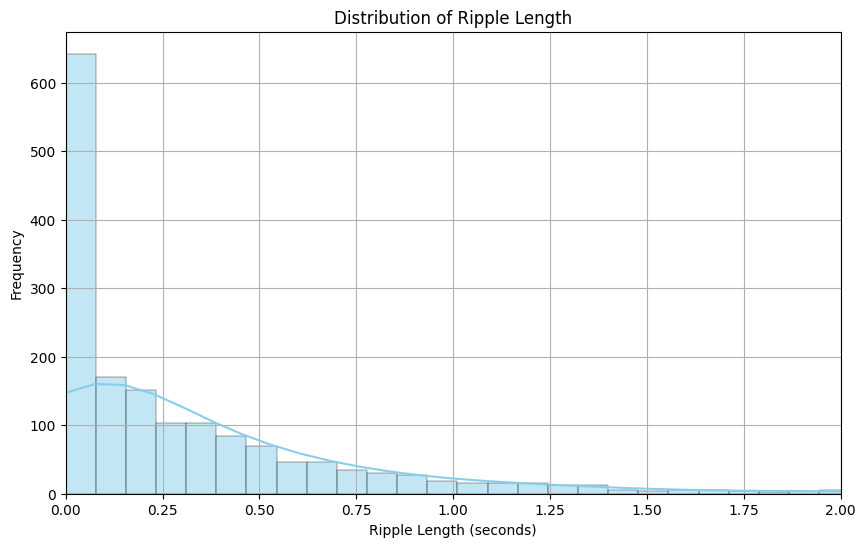

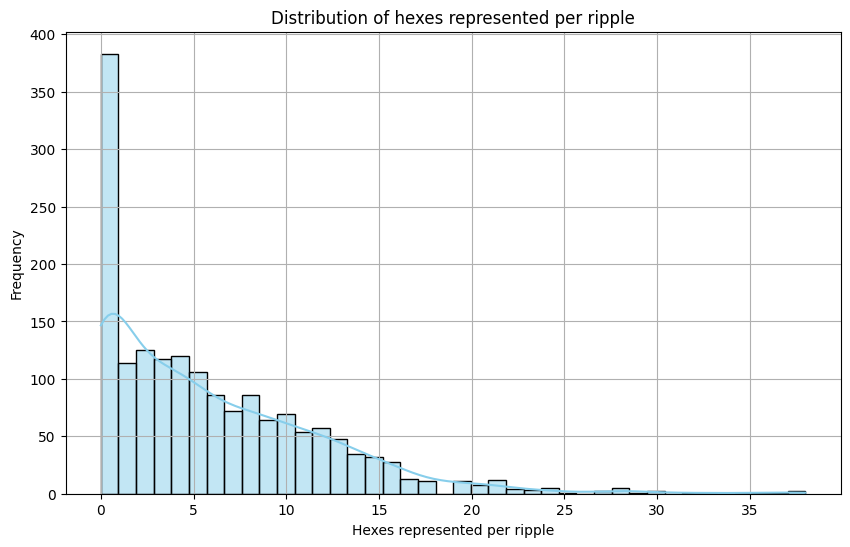

9893


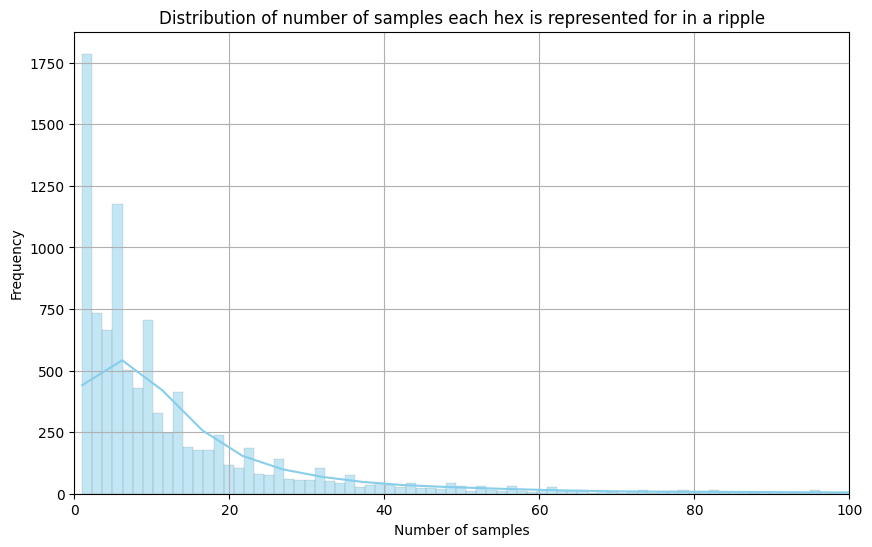

In [16]:
import seaborn as sns

# Distribution of ripple lengths
plt.figure(figsize=(10, 6))
sns.histplot(trial_df['ripple_length']/250, kde=True, color='skyblue')

plt.xlabel('Ripple Length (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Ripple Length')
plt.xlim(0, 2) 
plt.grid(True)
plt.show()

# Distribution of # hexes represented per ripple
plt.figure(figsize=(10, 6))
sns.histplot(trial_df['num_hexes_in_ripple'], kde=True, bins = 40, color='skyblue')
plt.xlabel('Hexes represented per ripple')
plt.ylabel('Frequency')
plt.title('Distribution of hexes represented per ripple')
plt.grid(True)
plt.show()

# number of samples per hex in a ripple
samples_per_hex_rep = [num_samples for d in trial_df['nonlocal_hex_reps'] for num_samples in d.values()]
print(len(samples_per_hex_rep))

plt.figure(figsize=(10, 6))
sns.histplot(samples_per_hex_rep, kde=True, color='skyblue')
plt.xlabel('Number of samples')
plt.ylabel('Frequency')
plt.title('Distribution of number of samples each hex is represented for in a ripple')
plt.xlim(0, 100) 
plt.grid(True)
plt.show()


Index(['session', 'block', 'port', 'maze', 'hex', 'mean_DA_diff',
       'mean_repped_DA', 'std_repped_DA', 'mean_non_repped_DA',
       'std_non_repped_DA'],
      dtype='object')


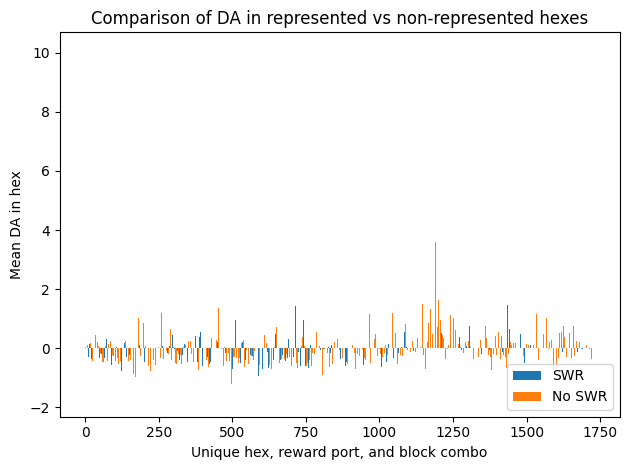

In [17]:
print(hex_DA_df.columns)

# Bar chart? might be awful but I wanna know
index = np.arange(len(hex_DA_df))
bar_width = 0.5

# Plot mean and std hex DA change
#plt.bar(index, hex_DA_df['mean_repped_DA_change'], bar_width, label='SWR', yerr=hex_DA_df['std_repped_DA_change'])
#plt.bar(index + bar_width, hex_DA_df['mean_non_repped_DA_change'], label='No SWR', yerr=hex_DA_df['std_non_repped_DA_change'])
plt.bar(index, hex_DA_df['mean_repped_DA'], bar_width, label='SWR')
plt.bar(index + bar_width, hex_DA_df['mean_non_repped_DA'], bar_width, label='No SWR')

# Add labels and title
plt.xlabel('Unique hex, reward port, and block combo')
plt.ylabel('Mean DA in hex')
plt.title('Comparison of DA in represented vs non-represented hexes')
plt.legend()

# Display plot
plt.tight_layout()
plt.show()

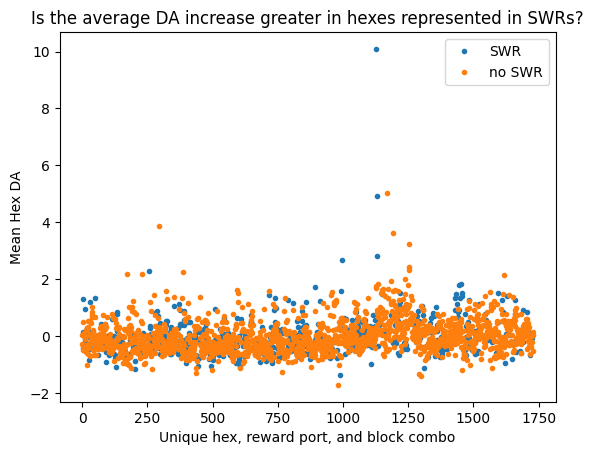

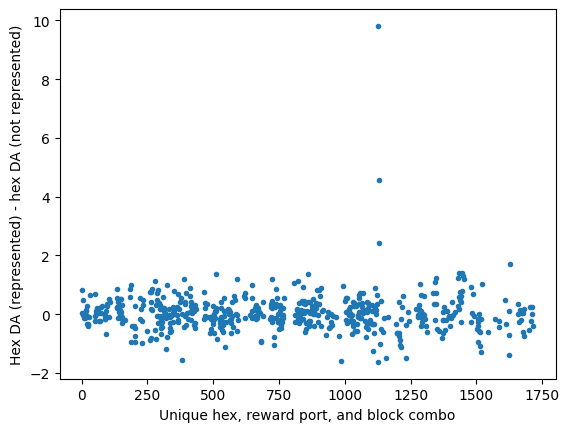

Mean DA difference in represented vs non represented hexes 0.04277838991399397
Std DA difference in represented vs non represented hexes 0.6756882429905915


In [18]:
idx = np.arange(len(hex_DA_df))

# Plot mean DA in represented and not represented hexes
# yerr=hex_DA_df['std_repped_DA']
plt.errorbar(idx, hex_DA_df['mean_repped_DA'], fmt='.', label='SWR', capsize=5)
plt.errorbar(idx, hex_DA_df['mean_non_repped_DA'], fmt='.', label='no SWR', capsize=5)
plt.xlabel('Unique hex, reward port, and block combo')
plt.ylabel('Mean Hex DA')
plt.title('Is the average DA increase greater in hexes represented in SWRs?')
plt.legend()
plt.show()

# Plot mean DA difference for represented vs not represented hexes
plt.figure()
plt.plot(idx, hex_DA_df['mean_DA_diff'], '.')
plt.xlabel('Unique hex, reward port, and block combo')
plt.ylabel('Hex DA (represented) - hex DA (not represented)')
plt.show()

print(f"Mean DA difference in represented vs non represented hexes {np.mean(hex_DA_df['mean_DA_diff'])}")
print(f"Std DA difference in represented vs non represented hexes {np.std(hex_DA_df['mean_DA_diff'])}")

#### Another version of the analysis above where I was messing with controlling for other variables (was the intermediate trial rewarded, etc.)

In [ ]:
from collections import defaultdict

# Go from nested dict to df once again... 
# still deciding how I want to represent things and it feels ugly but I'm fine
trial_df = nested_dict_to_df(trial_dict, metadata=True)
#display(trial_df)

# Find when the rat goes to the same reward port exactly 2 trials apart
trial_diff = 2

# Miminum number of samples a hex needs to be represented in a ripple for it to "count"
min_samples_repped = 1

# If we only want to look at path-dependent hexes
path_dependent_hexes_only = True

# Set up list of dicts to aggregate everything
hex_DA_stats = []

# Get subset of the df of when the rat goes to the same port in the same session and block
# We only compare hex DA within the same session and block, because we want the maze structure to be the same
for (session, block, port), same_port_df in trial_df.groupby(['session', 'block', 'port']):
    # Print some info about the df subset we're looking at
    print(f"Session: {session}, Block: {block}, Port: {port}")
    
    # Get the maze configuration for this session + block
    maze = same_port_df['barriers'].iloc[0]
    # Get the path-independent hexes to the reward port
    # (need to add 1 here to change port from 0,1,2 to corresponding port hex 1,2,3)
    path_independent_hexes = get_path_independent_hexes_to_port(maze, port+1)
    
    # Set up dicts to store changes in DA across all trials in this block
    DA_change_repped_hexes = defaultdict(list)
    DA_change_non_repped_hexes = defaultdict(list)

    # Sort by trial to ensure trials are in ascending order (just in case)
    same_port_df = same_port_df.sort_values(by='trial')
    # Iterate through each row (trial)
    for i in range(len(same_port_df) - 2):
        prev_trial_at_port = same_port_df.iloc[i]
        trial_at_port = same_port_df.iloc[i + 1]
        
        # Only consider port entries that differ by exactly 2 trials
        if not (prev_trial_at_port['trial'] + trial_diff == trial_at_port['trial']):
            continue
        # Only consider trials where the rat was rewarded in the previous trial
        if not (prev_trial_at_port['rwd'] == 1):
            continue
        
        # TEST: Control for some condition on the intermediate trial? 
        # For now, it must be unrewarded (likely no ripples to mess us up)
        #intermediate_trial_df = trial_df[(trial_df['session'] == session) &
        #                                (trial_df['block'] == block) &
        #                                (trial_df['trial'] == trial_at_port['trial']-1)]
        #if intermediate_trial_df['rwd'].iloc[0] == 1:
        #    continue

        # Get the mean DA in each hex the rat ran through on the previous trial
        prev_hex_da = dict(zip(prev_trial_at_port['hex_path'], prev_trial_at_port['mean_hex_da']))

        # Get the mean DA in each hex the rat ran through in the current trial
        current_hex_da = dict(zip(trial_at_port['hex_path'], trial_at_port['mean_hex_da']))

        # Get hexes represented in the post-reward ripple on the previous trial
        nonlocal_hex_reps = [hex for hex, samples_repped 
                             in prev_trial_at_port['nonlocal_hex_reps'].items() 
                             if samples_repped >= min_samples_repped]
        
        # Get the change in DA for hexes that were represented in ripples after the previous trial
        repped_hexes_with_DA_diff = set(prev_hex_da.keys()) & set(current_hex_da.keys()) & set(nonlocal_hex_reps)
        if path_dependent_hexes_only:
            repped_hexes_with_DA_diff = repped_hexes_with_DA_diff - set(path_independent_hexes)
        DA_change_repped_hexes_this_trial = {hex: current_hex_da[hex] - prev_hex_da[hex] for hex in repped_hexes_with_DA_diff}
        
        # Get the change in DA for hexes that were NOT represented in ripples after the previous trial
        non_repped_hexes_with_DA_diff = set(prev_hex_da.keys()) & set(current_hex_da.keys()) - set(nonlocal_hex_reps)
        if path_dependent_hexes_only:
            non_repped_hexes_with_DA_diff = non_repped_hexes_with_DA_diff - set(path_independent_hexes)
        DA_change_non_repped_hexes_this_trial = {hex: current_hex_da[hex] - prev_hex_da[hex] for hex in non_repped_hexes_with_DA_diff}

        # Add DA changes for this trial to our block-level dicts for this port
        for hex, DA_change in DA_change_repped_hexes_this_trial.items():
            DA_change_repped_hexes[hex].append(DA_change)
        for hex, DA_change in DA_change_non_repped_hexes_this_trial.items():
            DA_change_non_repped_hexes[hex].append(DA_change)
    
    # Now for each block/port, we have a dictionary of change in hex DA 
    # both for hexes represented in ripples and those not represented in ripples.
    # We want to see if this DA increase is higher for hexes represented!!
    hexes_to_compare = set(DA_change_repped_hexes.keys()).intersection(DA_change_non_repped_hexes.keys())

    for hex in hexes_to_compare:
        mean_repped_DA_change = np.mean(DA_change_repped_hexes[hex])
        std_repped_DA_change = np.std(DA_change_repped_hexes[hex])
        mean_non_repped_DA_change = np.mean(DA_change_non_repped_hexes[hex])
        std_non_repped_DA_change = np.std(DA_change_non_repped_hexes[hex])
        mean_DA_diff = mean_repped_DA_change - mean_non_repped_DA_change
    
        # Add a bunch of stats. Not sure which we will want yet
        hex_DA_stats.append({'session': session,
                             'block': block,
                             'port': port,
                             'maze': maze,
                             'hex': hex,
                             'mean_DA_diff': mean_DA_diff, 
                             'mean_repped_DA_change': mean_repped_DA_change, 
                             'std_repped_DA_change': std_repped_DA_change,
                             'mean_non_repped_DA_change': mean_non_repped_DA_change, 
                             'std_non_repped_DA_change': std_non_repped_DA_change})

hex_DA_df = pd.DataFrame(hex_DA_stats)
display(hex_DA_df)

Session: 1, Block: 1, Port: 0
Session: 1, Block: 1, Port: 1
Session: 1, Block: 1, Port: 2
Session: 1, Block: 2, Port: 0
Session: 1, Block: 2, Port: 1
Session: 1, Block: 2, Port: 2
Session: 1, Block: 3, Port: 0
Session: 1, Block: 3, Port: 1
Session: 1, Block: 3, Port: 2
Session: 2, Block: 1, Port: 0
Session: 2, Block: 1, Port: 1
Session: 2, Block: 1, Port: 2
Session: 2, Block: 2, Port: 0
Session: 2, Block: 2, Port: 1
Session: 2, Block: 2, Port: 2
Session: 3, Block: 1, Port: 0
Session: 3, Block: 1, Port: 1
Session: 3, Block: 1, Port: 2
Session: 3, Block: 2, Port: 0
Session: 3, Block: 2, Port: 1
Session: 3, Block: 2, Port: 2
Session: 4, Block: 1, Port: 0
Session: 4, Block: 1, Port: 1
Session: 4, Block: 1, Port: 2
Session: 4, Block: 2, Port: 0
Session: 4, Block: 2, Port: 1
Session: 4, Block: 2, Port: 2
Session: 4, Block: 3, Port: 0
Session: 4, Block: 3, Port: 1
Session: 4, Block: 3, Port: 2
Session: 5, Block: 1, Port: 0
Session: 5, Block: 1, Port: 1
Session: 5, Block: 1, Port: 2
Session: 5

,session,block,port,maze,hex,mean_DA_diff,mean_repped_DA_change,std_repped_DA_change,mean_non_repped_DA_change,std_non_repped_DA_change
0,1,1,0,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",32,-1.196289,-0.959473,0.502441,0.236450,0.416504
1,1,1,0,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",37,0.225098,0.093506,0.315674,-0.131592,1.545898
2,1,1,0,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",31,0.352051,0.039001,0.009705,-0.312988,0.357910
3,1,2,0,"{35, 8, 9, 42, 44, 18, 21, 23, 27}",33,0.121948,-0.062622,0.000000,-0.184570,0.571777
4,1,2,0,"{35, 8, 9, 42, 44, 18, 21, 23, 27}",34,-0.106079,-0.237549,0.000000,-0.131470,0.456543
...,...,...,...,...,...,...,...,...,...,...
176,10,2,2,"{32, 34, 35, 12, 13, 46, 15, 45, 21}",37,0.467041,0.261230,0.000000,-0.205811,0.361572
177,10,2,2,"{32, 34, 35, 12, 13, 46, 15, 45, 21}",42,-0.457520,-0.671875,0.000000,-0.214478,0.561035
178,10,2,2,"{32, 34, 35, 12, 13, 46, 15, 45, 21}",43,-1.557617,-1.505859,0.000000,0.052002,0.875977
179,10,2,2,"{32, 34, 35, 12, 13, 46, 15, 45, 21}",14,2.359375,1.263672,0.258789,-1.095703,0.000000
